# Init

In [126]:
! pip install gamspy

In [127]:
! gamspy install license 204a1a5e-5e64-4583-a281-508165b2ee7e

In [128]:
import pandas as pd
from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense, Alias
import numpy as np
import itertools

# Data

In [129]:
# Load the CSV file into csv_data
csv_data = pd.read_csv("edge_distances_osrm.csv")

csv_data['valid'] = True
# Display the first few rows of the DataFrame
flipped_data = csv_data.copy()
flipped_data['from_node'], flipped_data['to_node'] = csv_data['to_node'], csv_data['from_node']

# Append the flipped data to the original to create an undirected graph
csv_data = pd.concat([csv_data, flipped_data], ignore_index=True)

csv_data

,edge_name,distance_m,duration_s,from_node,to_node,distance_km,duration_min,avg_speed_kmh,u_ij,a_ij,valid
0,E18 North,9333.6,628.5,Täby,Bergshamra,9.3336,10.475000,53.462148,2000,3.182180,True
1,E18 South,8989.9,704.5,Bergshamra,T-Centralen,8.9899,11.741667,45.938453,2000,2.838893,True
2,E20 East,8025.1,857.8,Lidingö,T-Centralen,8.0251,14.296667,33.679599,2000,2.331546,True
3,279 West,15364.8,1137.2,Vällingby,Bergshamra,15.3648,18.953333,48.639887,1200,1.055223,True
4,275 West,13454.3,1302.3,Vällingby,T-Centralen,13.4543,21.705000,37.192260,1200,0.921447,True
5,E20 South,8900.0,623.6,Skärholmen,Årstaberg,8.9000,10.393333,51.379089,2000,3.207184,True
6,75 Mid,4200.4,312.2,Årstaberg,Avicii Arena,4.2004,5.203333,48.435106,800,2.562460,True
7,73 South,9457.5,856.9,Farsta Shopping Centre,Avicii Arena,9.4575,14.281667,39.732758,800,0.933598,True
8,271 West,14464.8,1215.1,Skärholmen,Farsta Shopping Centre,14.4648,20.251667,42.855139,1200,0.987573,True
9,222 East,9847.3,855.9,Nacka Forum,T-Centralen,9.8473,14.265000,41.418717,1200,1.402033,True


### Demand split

In [130]:
# Chat Gpt generated
# Construct the DataFrame
data = {
    "Node": [
        "Farsta Shopping Centre", "Skärholmen", "Vällingby", "Täby", "Lidingö",
        "Nacka Forum", "Sollentuna", "Bergshamra", "Avicii Arena", "Årstaberg", "T-Centralen"
    ],
    "Approx. Population": [
        60_523, 33_662, 71_042, 77_744, 48_162, 110_633, 76_237, 7_300, 70_779, 12_486, 40_312
    ],
    "Source": [
        "Farsta borough (2022 estimate)",
        "Skärholmen borough (2004)",
        "Hässelby-Vällingby borough (2014)",
        "Täby Municipality (31 Dec 2024)",
        "Lidingö urban area (2023)",
        "Nacka Municipality (2023)",
        "Sollentuna Municipality (2022)",
        "Bergshamra suburb (approx.)",
        "Östermalm borough (2014)",
        "Årsta locality (recent)",
        "Norrmalm district"
    ]
}

_df = pd.DataFrame(data)


In [131]:
_init = np.diag(data["Approx. Population"])
skew = 0.9

d, _ = _init.shape

for i in range(d):
    pop = _init[i,i]
    if i != d-1:
        r_pop = int(pop*(1-skew)/(d-2))
        t_pop = pop-r_pop*(d-2)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Restore the i-th value (keep it the same as before)
        _init[i, i] = pop

        # Set the last value to t_pop
        _init[-1, i] = -t_pop
    else:
        r_pop = int(pop/(d-1))
        t_pop = r_pop*(d-1)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Set the last value to t_pop
        _init[-1, i] = t_pop

_init = _init.astype(int)

df_init = pd.DataFrame(_init, index=data['Node'], columns=data['Node'])

In [132]:
df_flow = df_init.melt(ignore_index=False).reset_index().rename(columns={"index": "Node", "variable": "Origin Flow", 0: "Distance"}).dropna().set_index(["Node", "Origin Flow"]).sort_index().reset_index()
df_flow.head(20)

,Node,Origin Flow,value
0,Avicii Arena,Avicii Arena,70779
1,Avicii Arena,Bergshamra,-81
2,Avicii Arena,Farsta Shopping Centre,-672
3,Avicii Arena,Lidingö,-535
4,Avicii Arena,Nacka Forum,-1229
5,Avicii Arena,Skärholmen,-374
6,Avicii Arena,Sollentuna,-847
7,Avicii Arena,T-Centralen,-4031
8,Avicii Arena,Täby,-863
9,Avicii Arena,Vällingby,-789


# Masking the Set

In [133]:
# Create all possible combinations of from_node and to_node
all_combinations = list(itertools.product(data['Node'], data['Node']))
result_df = pd.DataFrame(all_combinations, columns=['from_node', 'to_node'])

# Create a set of tuples from the original DataFrame for quick lookup
existing_pairs = set(zip(csv_data['from_node'], csv_data['to_node']))

# Add a column 'value' where 1 indicates the pair exists in csv_data, 0 otherwise
result_df['value'] = result_df.apply(lambda row: 1 if (row['from_node'], row['to_node']) in existing_pairs or (row['to_node'], row['from_node']) in existing_pairs else 0, axis=1)

# Display the resulting DataFrame
print(result_df['value'].sum())

34


# Problem 2 (1 is the KML files)

## Modeling

In [134]:
m = Container()

In [135]:
on_Node = Set(m, "from_Node", records=_df["Node"].tolist())
to_Node = Alias(m, "to_Node", on_Node)
Com_from = Alias(m, "Comuter_from", on_Node)

In [136]:
Flows = Parameter(m, "flows", domain=[on_Node, Com_from], description="the flow at Node for each commuter from Nodes_", records=df_flow[["Node", "Origin Flow", "value"]])
Valid_flows = Parameter(m, "valid_flows", domain=[on_Node, to_Node], description="the allowed flow at each Node for each commuter from Nodes_", records=result_df[["from_node", "to_node", "value"]])
Road_times = Parameter(m, "road_time", domain=[on_Node, to_Node], description="Time to travel on the road", records=csv_data[["from_node", "to_node", "duration_min"]])

In [137]:
Road_util = Variable(m, "road_util", domain=[on_Node, to_Node, Com_from], type='positive', description="Roads to be used by commuter from node")

In [138]:
Flow_parity = Equation(m, "flow_parity", domain=[on_Node, Com_from], description="Flow parity equation")

Flow_parity[on_Node, Com_from] = (
    Sum(to_Node, Valid_flows[on_Node, to_Node]*(Road_util[on_Node, to_Node, Com_from])) - Sum(to_Node, Valid_flows[on_Node, to_Node]*(Road_util[to_Node, on_Node, Com_from])) == Flows[on_Node, Com_from]
)

In [139]:
obj = (Sum((on_Node, to_Node),
     Road_times[on_Node, to_Node] 
     * Sum(Com_from, Road_util[on_Node, to_Node, Com_from])) 
     / Sum((Com_from), Flows[Com_from, Com_from])) # Average time for each car

In [140]:
LP = Model(m, equations=m.getEquations(), sense=Sense.MIN, objective=obj, name="LP")
LP.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,19.0275816091237,122,375,MIP,CPLEX,0.002


In [141]:
ru = Road_util.records
ru

,from_Node,to_Node,Comuter_from,level,marginal,lower,upper,scale
0,Farsta Shopping Centre,Skärholmen,Farsta Shopping Centre,672.0,0.000000,0.0,inf,1.0
1,Farsta Shopping Centre,Skärholmen,Skärholmen,0.0,0.000067,0.0,inf,1.0
2,Farsta Shopping Centre,Skärholmen,Vällingby,0.0,0.000048,0.0,inf,1.0
3,Farsta Shopping Centre,Skärholmen,Täby,0.0,0.000045,0.0,inf,1.0
4,Farsta Shopping Centre,Skärholmen,Lidingö,0.0,0.000031,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
369,T-Centralen,Avicii Arena,Sollentuna,1694.0,0.000000,0.0,inf,1.0
370,T-Centralen,Avicii Arena,Bergshamra,162.0,0.000000,0.0,inf,1.0
371,T-Centralen,Avicii Arena,Avicii Arena,0.0,0.000026,0.0,inf,1.0
372,T-Centralen,Avicii Arena,Årstaberg,0.0,0.000026,0.0,inf,1.0


In [142]:
sol_flows = ru[(ru["Comuter_from"] == "Sollentuna") & ~((ru["level"] == 0) & (ru["marginal"] != 0))].drop(columns=["Comuter_from"])
sol_flows

,from_Node,to_Node,level,marginal,lower,upper,scale
149,Sollentuna,Vällingby,847.0,0.0,0.0,inf,1.0
160,Sollentuna,Täby,847.0,0.0,0.0,inf,1.0
171,Sollentuna,Bergshamra,74543.0,0.0,0.0,inf,1.0
215,Bergshamra,Årstaberg,1694.0,0.0,0.0,inf,1.0
226,Bergshamra,T-Centralen,72002.0,0.0,0.0,inf,1.0
237,Avicii Arena,Farsta Shopping Centre,847.0,0.0,0.0,inf,1.0
281,Årstaberg,Skärholmen,847.0,0.0,0.0,inf,1.0
336,T-Centralen,Lidingö,847.0,0.0,0.0,inf,1.0
347,T-Centralen,Nacka Forum,847.0,0.0,0.0,inf,1.0
369,T-Centralen,Avicii Arena,1694.0,0.0,0.0,inf,1.0


## Plotting

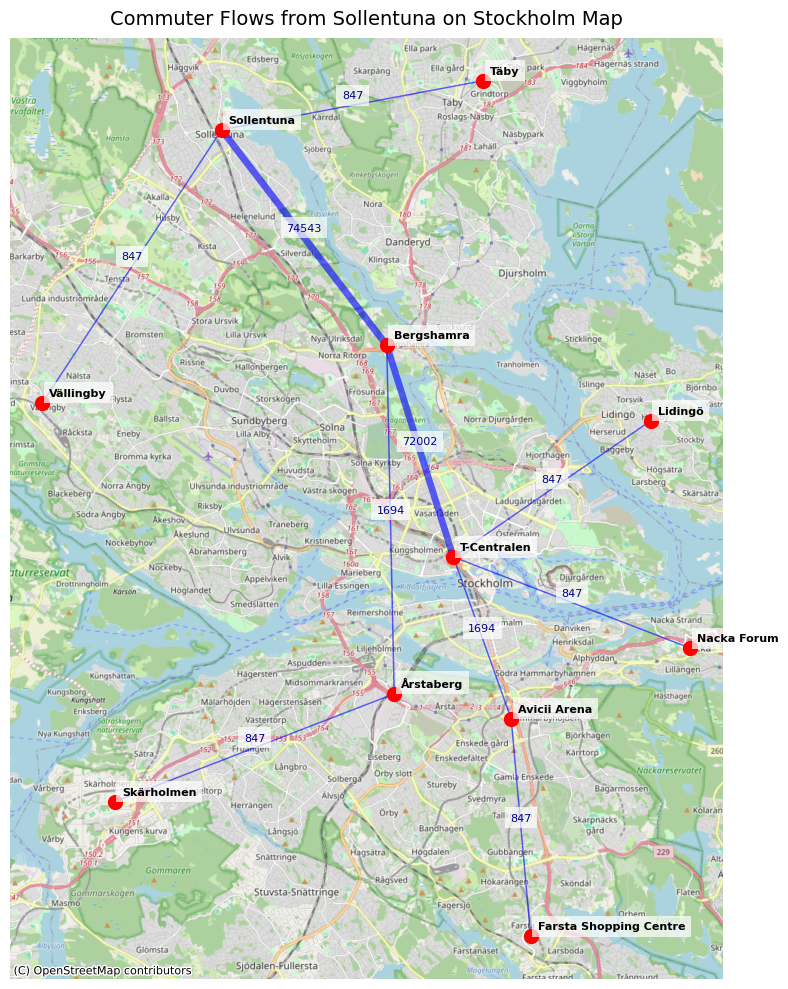

In [143]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString
from pykml import parser

# Path to the KML file (update if necessary)
kml_file_path = "Nodes.kml"

# Parse KML to extract coordinates and names
def parse_kml(file_path):
    with open(file_path, 'r') as f:
        kml_obj = parser.parse(f).getroot()
    coords_dict = {}
    labels_dict = {}
    for placemark in kml_obj.Document.Placemark:
        name = placemark.name.text
        labels_dict[name] = name  # Use Placemark name as label
        coords = placemark.Point.coordinates.text.strip().split(',')
        lon, lat = float(coords[0]), float(coords[1])
        coords_dict[name] = (lon, lat)
    return coords_dict, labels_dict

coords, node_labels = parse_kml(kml_file_path)

# Filter to include only positive flows
positive_flows = sol_flows[sol_flows['level'] > 0].copy()

# Create GeoDataFrame for nodes
nodes = pd.DataFrame({
    'name': list(coords.keys()),
    'geometry': [Point(lon, lat) for lon, lat in coords.values()]
})
nodes_gdf = gpd.GeoDataFrame(nodes, geometry='geometry', crs="EPSG:4326")

# Create GeoDataFrame for arcs
arcs = []
for _, row in positive_flows.iterrows():
    from_node = row['from_Node']
    to_node = row['to_Node']
    if from_node in coords and to_node in coords:
        line = LineString([Point(coords[from_node]), Point(coords[to_node])])
        arcs.append({
            'from_node': from_node,
            'to_node': to_node,
            'level': row['level'],
            'geometry': line
        })

arcs_gdf = gpd.GeoDataFrame(arcs, geometry='geometry', crs="EPSG:4326")

# Project to Web Mercator for compatibility with basemap
nodes_gdf = nodes_gdf.to_crs(epsg=3857)
arcs_gdf = arcs_gdf.to_crs(epsg=3857)

# Calculate line widths based on level
max_level = arcs_gdf['level'].max()
arcs_gdf['linewidth'] = arcs_gdf['level'].apply(lambda x: 1 + 4 * x / max_level)  # Scale 1 to 5

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot arcs
arcs_gdf.plot(ax=ax, linewidth=arcs_gdf['linewidth'], color='blue', alpha=0.6)

# Plot nodes
nodes_gdf.plot(ax=ax, color='red', markersize=100, zorder=2)

# Add node labels using KML Placemark names
for idx, row in nodes_gdf.iterrows():
    label = node_labels.get(row['name'], row['name'])
    ax.annotate(
        label,
        xy=(row.geometry.x, row.geometry.y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,  # Smaller font to handle longer names
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add arc labels (level values)
for idx, row in arcs_gdf.iterrows():
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    ax.annotate(
        int(row['level']),
        xy=(midpoint.x, midpoint.y),
        xytext=(0, 5),
        textcoords="offset points",
        fontsize=8,
        color='darkblue',
        ha='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Set title and adjust plot
ax.set_title("Commuter Flows from Sollentuna on Stockholm Map", fontsize=14, pad=10)
ax.set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()

Shortest Paths from Sollentuna (by Duration):
To Avicii Arena:
  Duration: 32.01 minutes
  Path: Sollentuna -> Bergshamra -> T-Centralen -> Avicii Arena
To Bergshamra:
  Duration: 12.40 minutes
  Path: Sollentuna -> Bergshamra
To Farsta Shopping Centre:
  Duration: 46.29 minutes
  Path: Sollentuna -> Bergshamra -> T-Centralen -> Avicii Arena -> Farsta Shopping Centre
To Lidingö:
  Duration: 38.44 minutes
  Path: Sollentuna -> Bergshamra -> T-Centralen -> Lidingö
To Nacka Forum:
  Duration: 38.41 minutes
  Path: Sollentuna -> Bergshamra -> T-Centralen -> Nacka Forum
To Skärholmen:
  Duration: 38.87 minutes
  Path: Sollentuna -> Bergshamra -> Årstaberg -> Skärholmen
To Sollentuna:
  Duration: 0.00 minutes
  Path: Sollentuna
To T-Centralen:
  Duration: 24.14 minutes
  Path: Sollentuna -> Bergshamra -> T-Centralen
To Täby:
  Duration: 17.80 minutes
  Path: Sollentuna -> Täby
To Vällingby:
  Duration: 18.13 minutes
  Path: Sollentuna -> Vällingby
To Årstaberg:
  Duration: 28.47 minutes
  Pa

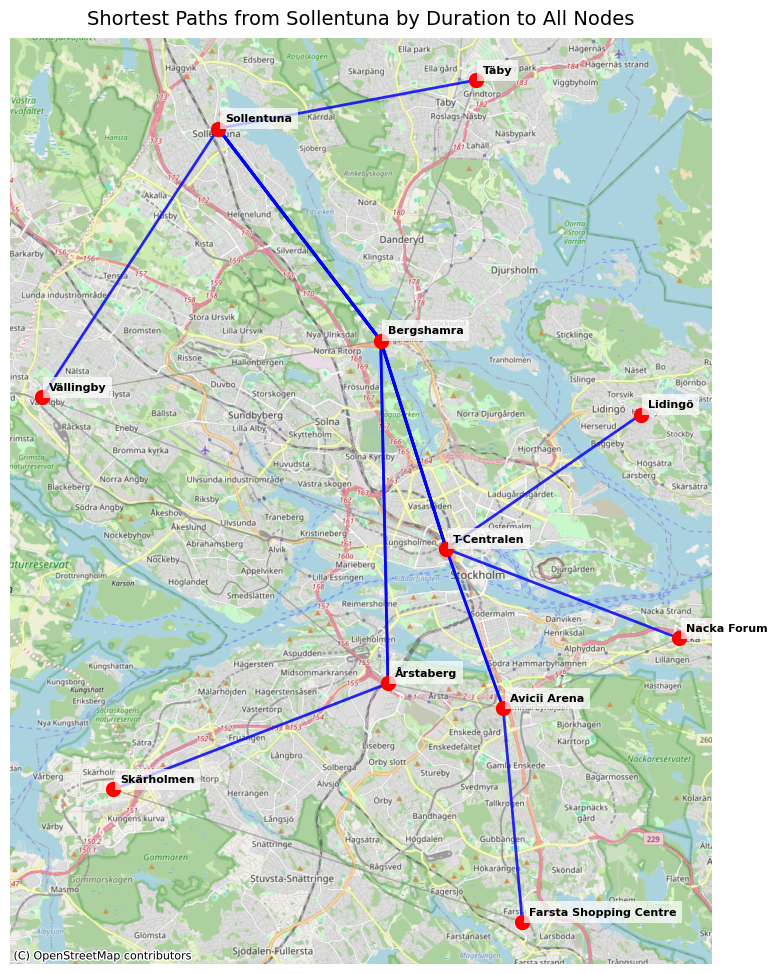

In [144]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString
from heapq import heappush, heappop

# Create undirected graph: adjacency list of (node, duration_min)
nodes = set(csv_data["from_node"]).union(set(csv_data["to_node"]))
graph = {node: [] for node in nodes}
for _, row in csv_data.iterrows():
    graph[row["from_node"]].append((row["to_node"], row["duration_min"]))
    graph[row["to_node"]].append((row["from_node"], row["duration_min"]))  # Add reverse edge for undirected graph

# Dijkstra's algorithm
def dijkstra(graph, start):
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    predecessors = {node: None for node in graph}
    pq = [(0, start)]
    while pq:
        current_distance, current_node = heappop(pq)
        if current_distance > distances[current_node]:
            continue
        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heappush(pq, (distance, neighbor))
    return distances, predecessors

# Get shortest paths
def get_path(predecessors, end):
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessors[current]
    return path[::-1]

distances, predecessors = dijkstra(graph, "Sollentuna")
shortest_paths = {}
for node in nodes:
    if distances[node] != float('inf'):
        path = get_path(predecessors, node)
        shortest_paths[node] = {"duration_min": distances[node], "path": path}

# Print shortest paths
print("Shortest Paths from Sollentuna (by Duration):")
for node, info in sorted(shortest_paths.items()):  # Sort for consistent output
    print(f"To {node}:")
    print(f"  Duration: {info['duration_min']:.2f} minutes")
    print(f"  Path: {' -> '.join(info['path'])}")

# Create GeoDataFrame for shortest paths
path_arcs = []
for node, info in shortest_paths.items():
    if node != "Sollentuna":
        path = info["path"]
        for i in range(len(path) - 1):
            from_node = path[i]
            to_node = path[i + 1]
            if from_node in coords and to_node in coords:
                line = LineString([Point(coords[from_node]), Point(coords[to_node])])
                path_arcs.append({
                    "from_node": from_node,
                    "to_node": to_node,
                    "destination": node,
                    "geometry": line
                })

paths_gdf = gpd.GeoDataFrame(path_arcs, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# Create GeoDataFrame for all edges (for context)
arcs = []
for _, row in csv_data.iterrows():
    if row["from_node"] in coords and row["to_node"] in coords:
        line = LineString([Point(coords[row["from_node"]]), Point(coords[row["to_node"]])])
        arcs.append({"geometry": line})
arcs_gdf = gpd.GeoDataFrame(arcs, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# Create GeoDataFrame for nodes
nodes_gdf = gpd.GeoDataFrame(
    {"name": list(coords.keys()), "geometry": [Point(lon, lat) for lon, lat in coords.values()]},
    geometry='geometry', crs="EPSG:4326"
).to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
arcs_gdf.plot(ax=ax, color='gray', alpha=0.3, linewidth=1)  # All edges in faint gray
paths_gdf.plot(ax=ax, color='blue', linewidth=2, alpha=0.8)  # Shortest paths in blue
nodes_gdf.plot(ax=ax, color='red', markersize=100, zorder=2)  # Nodes in red

# Add node labels
for idx, row in nodes_gdf.iterrows():
    ax.annotate(
        row['name'],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Set title and adjust plot
ax.set_title("Shortest Paths from Sollentuna by Duration to All Nodes", fontsize=14, pad=10)
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Problem 3 